Read in Data 

In [1]:
import pandas as pd

TRAIN = pd.read_csv("train_house.csv")
TEST = pd.read_csv("test_house.csv")

print(TRAIN.head())

print()

cat_col_names = TRAIN.select_dtypes(include=['object', 'category']).columns
print(cat_col_names)

print()

numeric_columns = TRAIN.select_dtypes(include=['number'])
print(numeric_columns.head())




   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

Na's in this data appear to represent lack of a feature not missing data. Therefore all Na's will be labeled none. Basically creating a class level none so nothing funny happens due to an NAN value

In [ ]:

cat_cols = TRAIN.select_dtypes(include=['object', 'category']).columns

TRAIN[cat_cols] = TRAIN[cat_cols].fillna("None")
TEST[cat_cols] = TEST[cat_cols].fillna("None")


In [3]:
print(TRAIN.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0   None  None        None       0      2   
1         Lvl    AllPub  ...        0   None  None        None       0      5   
2         Lvl    AllPub  ...        0   None  None        None       0      9   
3         Lvl    AllPub  ...        0   None  None        None       0      2   
4         Lvl    AllPub  ...        0   None  None        None       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

Correlations with SalePrice

In [ ]:

numeric_data = TRAIN.select_dtypes(include=['number'])

saleprice_corr = numeric_data.corr()['SalePrice'].sort_values(ascending=False)

print(saleprice_corr)
print()

strong_corr = saleprice_corr[abs(saleprice_corr) > 0.6]
strong_corr = strong_corr.drop('SalePrice')

print(strong_corr)




SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Forward Stepwise selection with numeric variables correlated over 0.6 and BldgType 

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrix

predictors = strong_corr.index.tolist()
predictors.append('BldgType')

X = TRAIN[predictors]
y = TRAIN['SalePrice']
X_encoded = pd.get_dummies(X, drop_first=True)

data = X_encoded.copy()
data['SalePrice'] = y

def quote_var(var):
    return f'Q("{var}")' if ' ' in var or '-' in var or var[0].isdigit() or not var.isidentifier() else var

def forward_stepwise(data, response_var, max_features=10):
    remaining = list(data.columns)
    remaining.remove(response_var)
    selected = []
    current_score = np.inf
    best_model = None

    while remaining and len(selected) < max_features:
        scores_with_candidates = []
        for candidate in remaining:
            try:
                formula = f"{response_var} ~ " + ' + '.join([quote_var(v) for v in selected + [candidate]])
                model = sm.OLS.from_formula(formula, data).fit()
                aic = model.aic
                scores_with_candidates.append((aic, candidate, model))
            except Exception as e:
                print(f"Error with candidate '{candidate}': {e}")

        if not scores_with_candidates:
            print("No valid candidates remaining.")
            break

        scores_with_candidates.sort()
        best_new_score, best_candidate, best_model_candidate = scores_with_candidates[0]

        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            best_model = best_model_candidate
        else:
            break

    return best_model, selected

final_model, selected_predictors = forward_stepwise(data, 'SalePrice')

print("Selected predictors:", selected_predictors)
print("\nModel Coefficients:\n", final_model.params)
print("\nModel Summary:\n", final_model.summary())



Selected predictors: ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', '1stFlrSF', 'BldgType_2fmCon']

Model Coefficients:
 Intercept                 -98543.975106
BldgType_Duplex[T.True]   -23188.169351
BldgType_Twnhs[T.True]    -18445.819946
BldgType_TwnhsE[T.True]   -11021.540976
BldgType_2fmCon[T.True]   -12882.520240
OverallQual                23825.684739
GrLivArea                     42.649386
TotalBsmtSF                   22.896441
GarageCars                 18238.460198
Q("1stFlrSF")                 13.395103
dtype: float64

Model Summary:
                             OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     530.8
Date:                Fri, 18 Apr 2025   Prob (F-statistic):     

1 fam is the reference level for bldgtype

In [ ]:

intercept = final_model.params[0]
coefficients = final_model.params[1:]

equation = f"SalePrice = {intercept:.2f}"
for variable, coef in coefficients.items():
    sign = "+" if coef >= 0 else "-"
    equation += f" {sign} {abs(coef):.2f}*{variable}"

print("\nModel Equation:\n", equation)



Model Equation:
 SalePrice = -98543.98 - 23188.17*BldgType_Duplex[T.True] - 18445.82*BldgType_Twnhs[T.True] - 11021.54*BldgType_TwnhsE[T.True] - 12882.52*BldgType_2fmCon[T.True] + 23825.68*OverallQual + 42.65*GrLivArea + 22.90*TotalBsmtSF + 18238.46*GarageCars + 13.40*Q("1stFlrSF")


C:\Users\jacob\AppData\Local\Temp\ipykernel_21760\1325621614.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = final_model.params[0]


Check for multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = data[selected_predictors].copy()

X_vif = X_vif.astype(float)

X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)



          Variable        VIF
0            const  24.309011
1      OverallQual   2.394646
2        GrLivArea   2.041671
3      TotalBsmtSF   3.494605
4       GarageCars   1.671957
5  BldgType_Duplex   1.089758
6   BldgType_Twnhs   1.052653
7  BldgType_TwnhsE   1.084269
8         1stFlrSF   3.826155
9  BldgType_2fmCon   1.036325


RMSE

In [ ]:
import numpy as np

residuals = final_model.resid

rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE: {rmse:.2f}")


RMSE: 38321.17


Making predictions on the test set

In [ ]:

TEST_encoded = pd.get_dummies(TEST[['BldgType']], drop_first=True)

expected_dummies = ['BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BldgType_2fmCon']
for col in expected_dummies:
    if col not in TEST_encoded.columns:
        TEST_encoded[col] = 0  

numeric_vars = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', '1stFlrSF']
for col in numeric_vars:
    TEST_encoded[col] = TEST[col]

for col in ['TotalBsmtSF', 'GarageCars']:
    TEST_encoded[col] = TEST_encoded[col].fillna(TEST[col].median())

TEST_encoded['SalePrice'] = (
    -98543.98
    - 23188.17 * TEST_encoded['BldgType_Duplex']
    - 18445.82 * TEST_encoded['BldgType_Twnhs']
    - 11021.54 * TEST_encoded['BldgType_TwnhsE']
    - 12882.52 * TEST_encoded['BldgType_2fmCon']
    + 23825.68 * TEST_encoded['OverallQual']
    + 42.65 * TEST_encoded['GrLivArea']
    + 22.90 * TEST_encoded['TotalBsmtSF']
    + 18238.46 * TEST_encoded['GarageCars']
    + 13.40 * TEST_encoded['1stFlrSF']
)


TEST['SalePrice'] = TEST_encoded['SalePrice']

print(TEST.head())


#TEST = TEST.iloc[:, [0, -1]]  # Keep only ID and saleprice
#TEST.to_csv("FSWmodel_1.csv", index=False)


     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave  None      Reg   
1  1462          20       RL         81.0    14267   Pave  None      IR1   
2  1463          60       RL         74.0    13830   Pave  None      IR1   
3  1464          60       RL         78.0     9978   Pave  None      IR1   
4  1465         120       RL         43.0     5005   Pave  None      IR1   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0   None  MnPrv        None       0   
1         Lvl    AllPub  ...        0   None   None        Gar2   12500   
2         Lvl    AllPub  ...        0   None  MnPrv        None       0   
3         Lvl    AllPub  ...        0   None   None        None       0   
4         HLS    AllPub  ...        0   None   None        None       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      6   2010        WD         Norm

Assumptions:

Linearity: Failed. Scatter plots show non-linear trends between predictors and response. 

Homoscedastic Variance: Failed. Low p-value associated with BP test suggest reject null hypothesis that residuals have constant variance.

Independent Observations: Passed. DW value close to 2.

Normality of Residuals: Failed. QQ-plot shows deviations from normality at both higher and lower theoretical quantiles. 

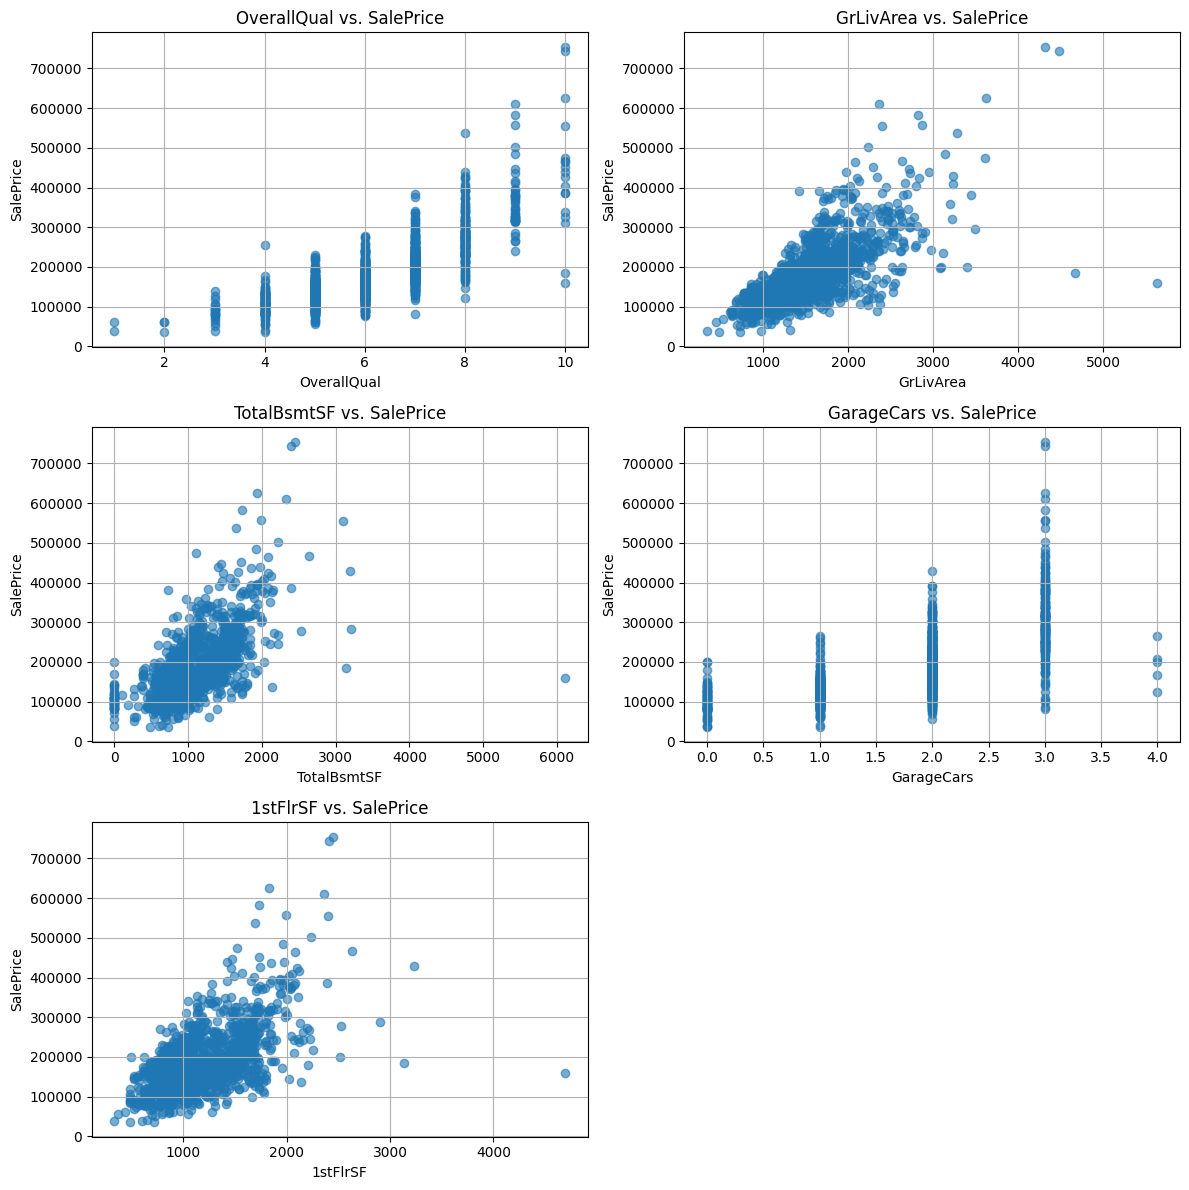

Breusch-Pagan Test Results:
Lagrange multiplier statistic: 386.2175
p-value: 0.0000
f-value: 57.9484
f p-value: 0.0000
Durbin-Watson statistic: 1.9767


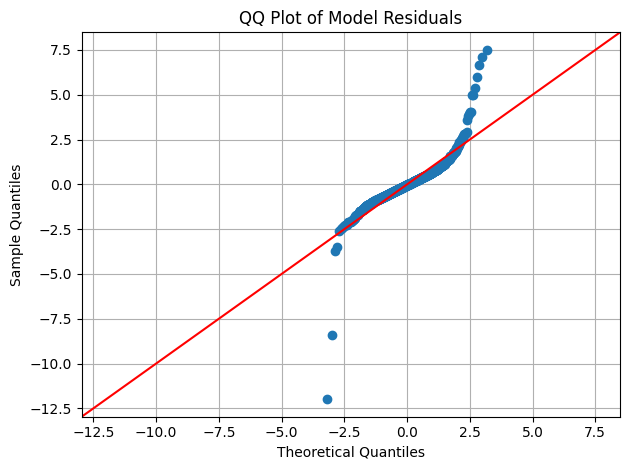

In [ ]:

# Scatterplots 
import matplotlib.pyplot as plt

def plot_numeric_predictors_vs_response(data, predictors, response):
    numeric_predictors = [p for p in predictors if np.issubdtype(data[p].dtype, np.number) and data[p].nunique() > 2]
    
    n_cols = 2
    n_rows = (len(numeric_predictors) + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()

    for i, predictor in enumerate(numeric_predictors):
        axes[i].scatter(data[predictor], data[response], alpha=0.6)
        axes[i].set_xlabel(predictor)
        axes[i].set_ylabel(response)
        axes[i].set_title(f'{predictor} vs. {response}')
        axes[i].grid(True)

    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_numeric_predictors_vs_response(data, selected_predictors, 'SalePrice')


#Homoscedastic Variance
from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan test
bp_test = het_breuschpagan(final_model.resid, final_model.model.exog)

bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_results = dict(zip(bp_labels, bp_test))

print("Breusch-Pagan Test Results:")
for k, v in bp_results.items():
    print(f"{k}: {v:.4f}")


#Independent Observations
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson test
dw_stat = durbin_watson(final_model.resid)

print(f"Durbin-Watson statistic: {dw_stat:.4f}")


#QQ-plot for Residuals
import statsmodels.api as sm
import matplotlib.pyplot as plt


def plot_qq(model):
    sm.qqplot(model.resid, line='45', fit=True)
    plt.title('QQ Plot of Model Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_qq(final_model)




Visualization of Numeric Training Variables

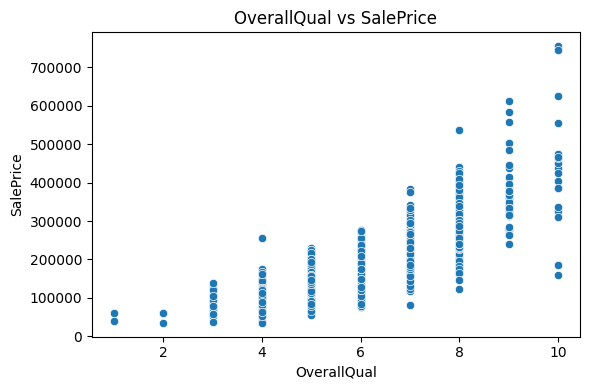

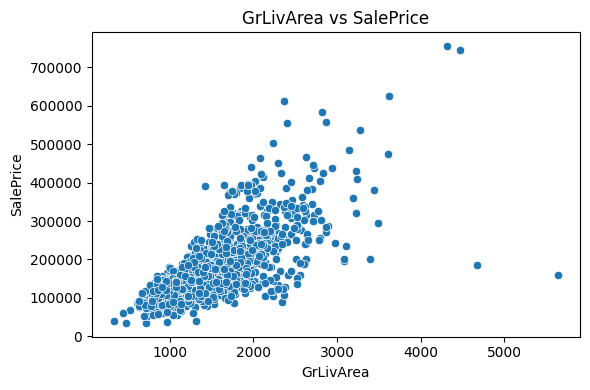

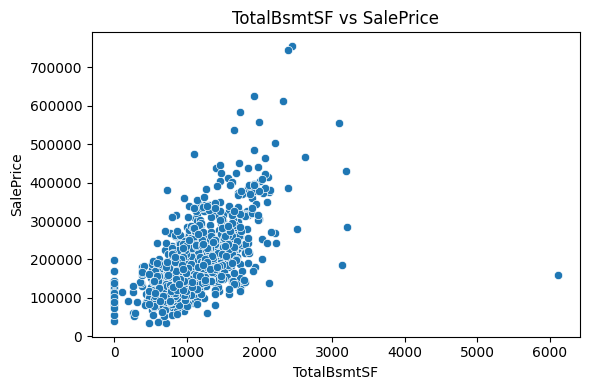

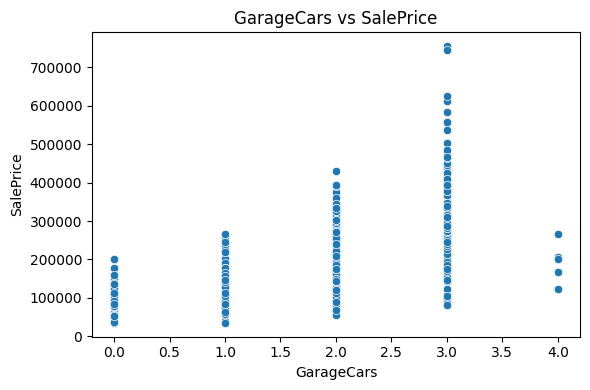

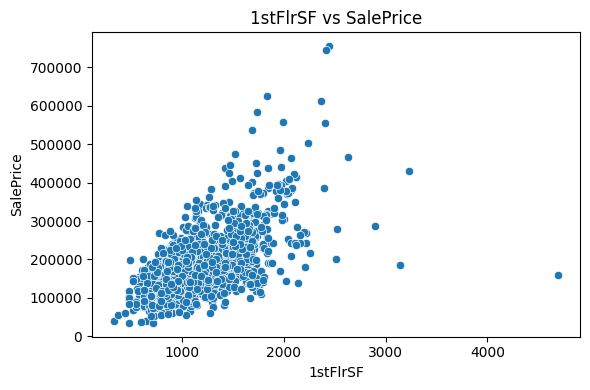

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


numeric_model_vars = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', '1stFlrSF']


for col in numeric_model_vars:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=TRAIN, x=col, y='SalePrice')
    plt.title(f'{col} vs SalePrice')
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.tight_layout()
    plt.show()


Square OverallQual and add interaction of basement and 1st floor square footage

In [ ]:

predictors = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', '1stFlrSF', 'BldgType']


X = TRAIN[predictors].copy()
y = TRAIN['SalePrice']


X['OverallQual_sq'] = X['OverallQual'] ** 2


X_encoded = pd.get_dummies(X, columns=['BldgType'], drop_first=True)

X_encoded['Flr_Bsmt_Interaction'] = X_encoded['1stFlrSF'] * X_encoded['TotalBsmtSF']


data = X_encoded.copy()
data['SalePrice'] = y


formula = (
    'SalePrice ~ OverallQual + OverallQual_sq + GrLivArea + TotalBsmtSF + GarageCars + Q("1stFlrSF") '
    '+ Flr_Bsmt_Interaction '
    '+ BldgType_Duplex + BldgType_Twnhs + BldgType_TwnhsE + BldgType_2fmCon'
)


model = sm.OLS.from_formula(formula, data).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     588.2
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:03:50   Log-Likelihood:                -17304.
No. Observations:                1460   AIC:                         3.463e+04
Df Residuals:                    1448   BIC:                         3.470e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                7

In [ ]:

coefs = model.params

equation = "SalePrice = "

for i, (name, coef) in enumerate(coefs.items()):
    if name == 'Intercept':
        equation += f"{coef:.2f} "
    else:
        sign = '+' if coef >= 0 else '-'
        equation += f"{sign} {abs(coef):.2f}*{name} "

print(equation)


SalePrice = 75345.19 - 24052.68*BldgType_Duplex[T.True] - 10583.61*BldgType_Twnhs[T.True] - 7958.97*BldgType_TwnhsE[T.True] - 15609.16*BldgType_2fmCon[T.True] - 49017.63*OverallQual + 5873.40*OverallQual_sq + 47.28*GrLivArea + 72.92*TotalBsmtSF + 14495.46*GarageCars + 35.49*Q("1stFlrSF") - 0.03*Flr_Bsmt_Interaction 


RMSE

In [ ]:
import numpy as np

residuals = model.resid


rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE: {rmse:.2f}")

RMSE: 33961.49


Predicting on Test Set

In [ ]:

X_test = TEST[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', '1stFlrSF', 'BldgType']].copy()

X_test['OverallQual_sq'] = X_test['OverallQual'] ** 2
X_test['Flr_Bsmt_Interaction'] = X_test['1stFlrSF'] * X_test['TotalBsmtSF']


X_test_encoded = pd.get_dummies(X_test, columns=['BldgType'], drop_first=True)


for col in ['BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BldgType_2fmCon']:
    if col not in X_test_encoded.columns:
        X_test_encoded[col] = 0  


X_test_encoded = X_test_encoded[
    ['OverallQual', 'OverallQual_sq', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', '1stFlrSF',
     'Flr_Bsmt_Interaction', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BldgType_2fmCon']
]

X_test_encoded = sm.add_constant(X_test_encoded)  
test_predictions = model.predict(X_test_encoded)


submission = pd.DataFrame({
    'Id': TEST['Id'],
    'SalePrice': test_predictions
})


submission['SalePrice'] = submission['SalePrice'].fillna(0)


#submission.to_csv('Reg_2.2_submission.csv', index=False)


Assumptions:

Dependent and independent variables can be modeled with a polynomial: Passed. Scatter plots show non-linear trends between predictors and response, especially overall quality. 

Homoscedastic Variance: Failed. Low p-value associated with BP test suggest reject null hypothesis that residuals have constant variance.

Independent Observations: Passed. DW value close to 2.

Normality of Residuals: Failed. QQ-plot shows deviations from normality at both higher and lower theoretical quantiles. 

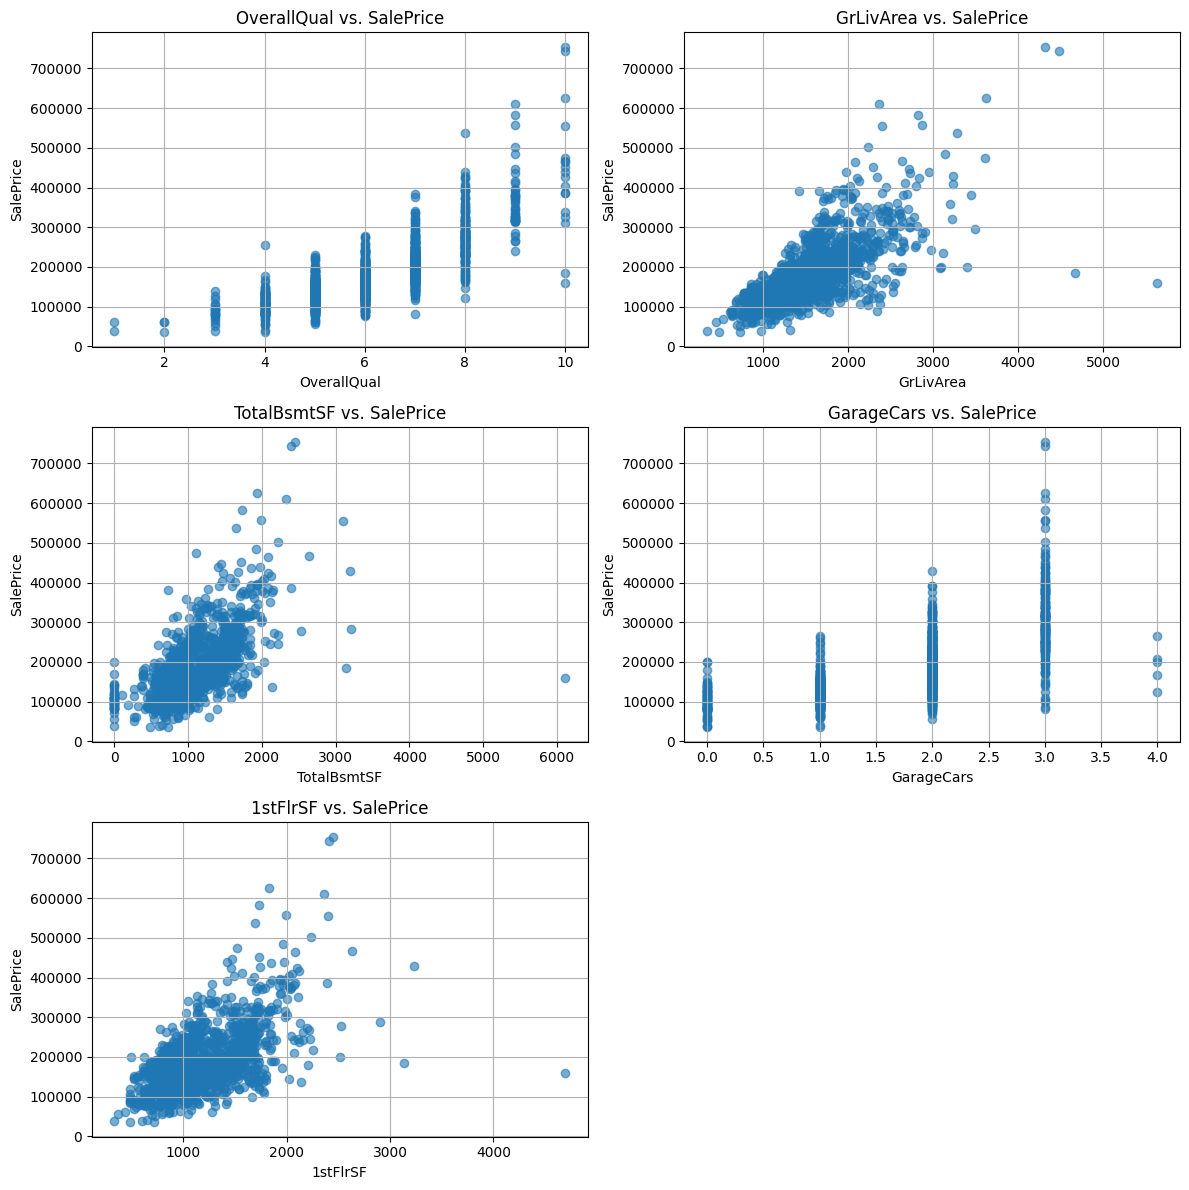

Breusch-Pagan Test Results:
Lagrange multiplier statistic: 328.0394
p-value: 0.0000
f-value: 38.1479
f p-value: 0.0000
Durbin-Watson statistic: 1.9811


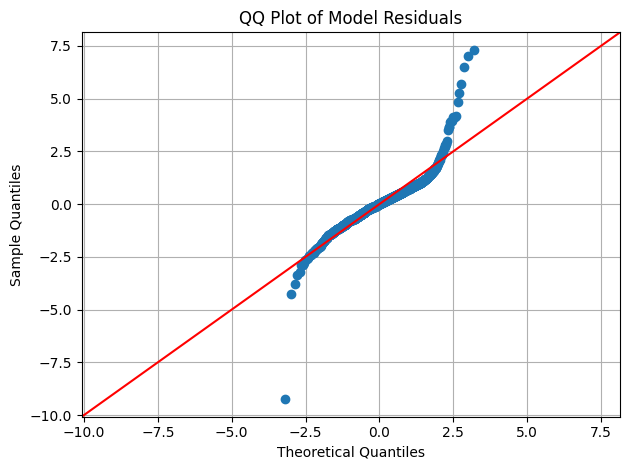

In [ ]:

# Scatterplots 
import matplotlib.pyplot as plt

def plot_numeric_predictors_vs_response(data, predictors, response):
    numeric_predictors = [p for p in predictors if np.issubdtype(data[p].dtype, np.number) and data[p].nunique() > 2]
    
    n_cols = 2
    n_rows = (len(numeric_predictors) + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()

    for i, predictor in enumerate(numeric_predictors):
        axes[i].scatter(data[predictor], data[response], alpha=0.6)
        axes[i].set_xlabel(predictor)
        axes[i].set_ylabel(response)
        axes[i].set_title(f'{predictor} vs. {response}')
        axes[i].grid(True)

    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_numeric_predictors_vs_response(data, selected_predictors, 'SalePrice')


#Homoscedastic Variance
from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)

bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_results = dict(zip(bp_labels, bp_test))

print("Breusch-Pagan Test Results:")
for k, v in bp_results.items():
    print(f"{k}: {v:.4f}")



#Independent Observations
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson test
dw_stat = durbin_watson(model.resid)

print(f"Durbin-Watson statistic: {dw_stat:.4f}")


#QQ-plot for Residuals
import statsmodels.api as sm
import matplotlib.pyplot as plt


def plot_qq(model):
    sm.qqplot(model.resid, line='45', fit=True)
    plt.title('QQ Plot of Model Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_qq(model)
